# 4.0 Feature Validation Trial 3

### Data Set Up

In [344]:
# Basic Operations
import pandas as pd
import numpy as np

# Data Visualization
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [391]:
# Reconstructed Data with Added Features (123)
aug_data = pd.read_csv("data/training-set-1/pose_data_augmented_res.csv")
Xa = aug_data.iloc[:,5:134]
ya = aug_data['label_encoded'].values

# Reconstructed Data with Improved Added Features(123)
aug_data2 = pd.read_csv("data/training-set-1/pose_data_augmented_res_z.csv")
aug_data2 = aug_data2.loc[:, ~aug_data2.columns.str.contains('_v')] #Removed Visibility Variable
Xa2 = aug_data2.iloc[:,5:134]
ya2 = aug_data2['label_encoded'].values

# Reconstructed Data with Reduced Noise + Improved Features(63)
Xa3 = pd.concat([aug_data2.iloc[:, 5:8], aug_data2.iloc[:, 38:56], aug_data2.iloc[:, 74:92], aug_data3.iloc[:, 104:]],axis=1)
ya3 = aug_data3['label_encoded'].values

# Readable Labels
poses_names = aug_data2['label'].values

#Scaled
scaler = StandardScaler()
Xa_scaled = scaler.fit_transform(Xa)
Xa2_scaled = scaler.fit_transform(Xa2)
Xa3_scaled = scaler.fit_transform(Xa3)

## 4.1 Cross Validation of Data Augmentation/Features Selection

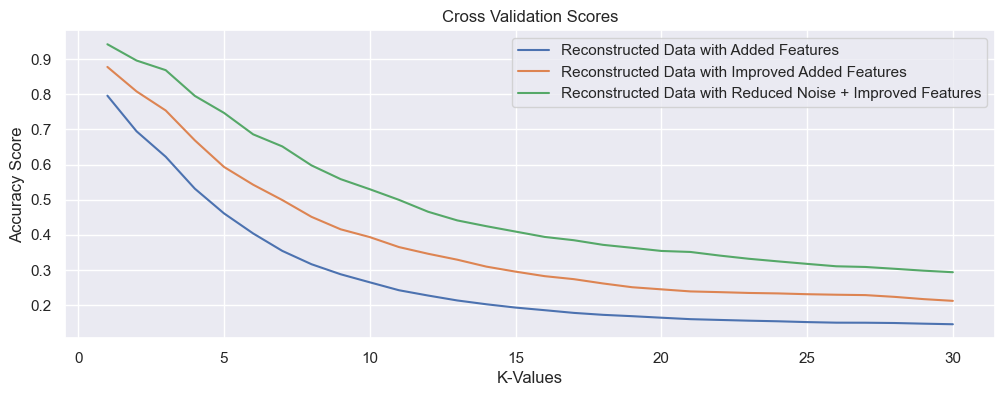

In [303]:
k_values = [i for i in range(1, 31)]

scores_Xa = []
scores_Xa2 = []
scores_Xa3 = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    
    knn.fit(Xa_scaled, ya)
    score_Xa = cross_val_score(knn, Xa_scaled, ya, cv=10, scoring='accuracy')
    scores_Xa.append(np.mean(score_Xa))
                            
    knn.fit(Xa2_scaled, ya2)
    score_Xa2 = cross_val_score(knn, Xa2_scaled, ya2, cv=10, scoring='accuracy')
    scores_Xa2.append(np.mean(score_Xa2))

    knn.fit(Xa3_scaled, ya2)
    score_Xa3 = cross_val_score(knn, Xa3_scaled, ya3, cv=10, scoring='accuracy')
    scores_Xa3.append(np.mean(score_Xa3))

sns.set(rc={'figure.figsize':(12,4)})
sns.lineplot(x = k_values, y = scores_Xa, label='Reconstructed Data with Added Features')
sns.lineplot(x = k_values, y = scores_Xa2, label='Reconstructed Data with Improved Added Features')
sns.lineplot(x = k_values, y = scores_Xa3, label='Reconstructed Data with Reduced Noise + Improved Features')
plt.title("Cross Validation Scores")
plt.xlabel('K-Values')
plt.ylabel('Accuracy Score')
plt.show()

In [308]:
# Find index of maximum accuracy for reconstructed data with added features
idx_max_Xa = np.argmax(scores_Xa)
optimal_k_Xa = k_values[idx_max_Xa]
max_accuracy_Xa = scores_Xa[idx_max_Xa]

# Find index of maximum accuracy for reconstructed data with improved features
idx_max_Xa2 = np.argmax(scores_Xa2)
optimal_k_Xa2 = k_values[idx_max_Xa2]
max_accuracy_Xa2 = scores_Xa2[idx_max_Xa2]

# Find index of maximum accuracy for reconstructed data with added/removed features
idx_max_Xa3 = np.argmax(scores_Xa3)
optimal_k_Xa3 = k_values[idx_max_Xa3]
max_accuracy_Xa3 = scores_Xa3[idx_max_Xa3]

print(f"Optimal K (All): {optimal_k_Xa} - Maximum Accuracy: {max_accuracy_Xa:.4f}")
print(f"Optimal K (Improved): {optimal_k_Xa2} - Maximum Accuracy: {max_accuracy_Xa2:.4f}")
print(f"Optimal K (Reduced and Improved): {optimal_k_Xa3} - Maximum Accuracy: {max_accuracy_Xa3:.4f}")

Optimal K (All): 1 - Maximum Accuracy: 0.7957
Optimal K (Improved): 1 - Maximum Accuracy: 0.8774
Optimal K (Reduced and Improved): 1 - Maximum Accuracy: 0.9418


## 4.2 Dimensionality Reduction Methods

Through dimensionality reduction methods, we aim to validate the contribution of features by transforming the data to a space where the most significant variances in PCA and class separability using LDA.

### 4.2.1 Principal Component Analysis

A scree plot analysis is instrumental in understanding the distribution of variance across principal components in high-dimensional data. The "elbow" in the plot typically represents the point beyond which additional components have a diminishing return on explaining the variance.

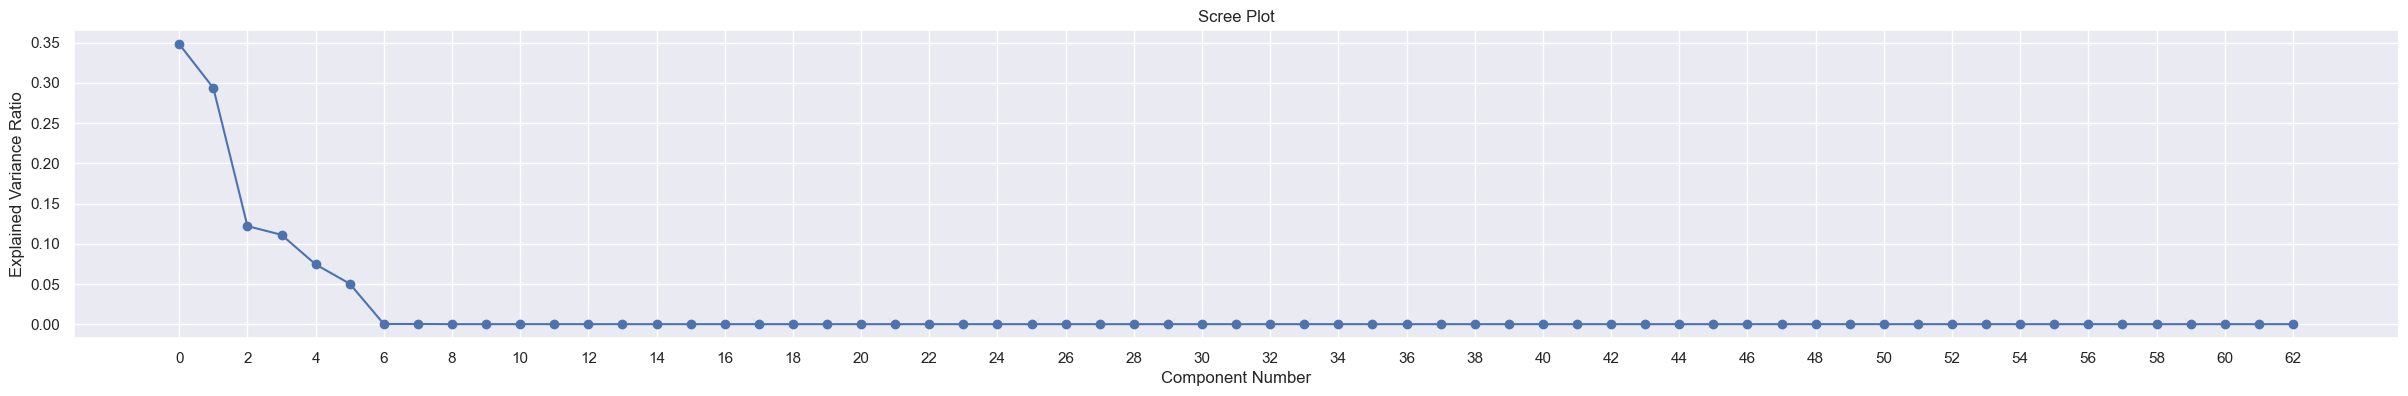

In [309]:
pca = PCA()
Xa_pca = pca.fit_transform(Xa3)

explained_variance_ratio = pca.explained_variance_ratio_
components = pca.components_  

sns.set(rc={'figure.figsize':(30,4)})
plt.plot(explained_variance_ratio, marker='o')
plt.xticks(range(len(explained_variance_ratio))[::2])
plt.xlabel("Component Number")
plt.ylabel("Explained Variance Ratio")
plt.title("Scree Plot")
plt.grid(True)
plt.show()

Multiple inflection points were observed between 0-6 before it reaches a flat line.

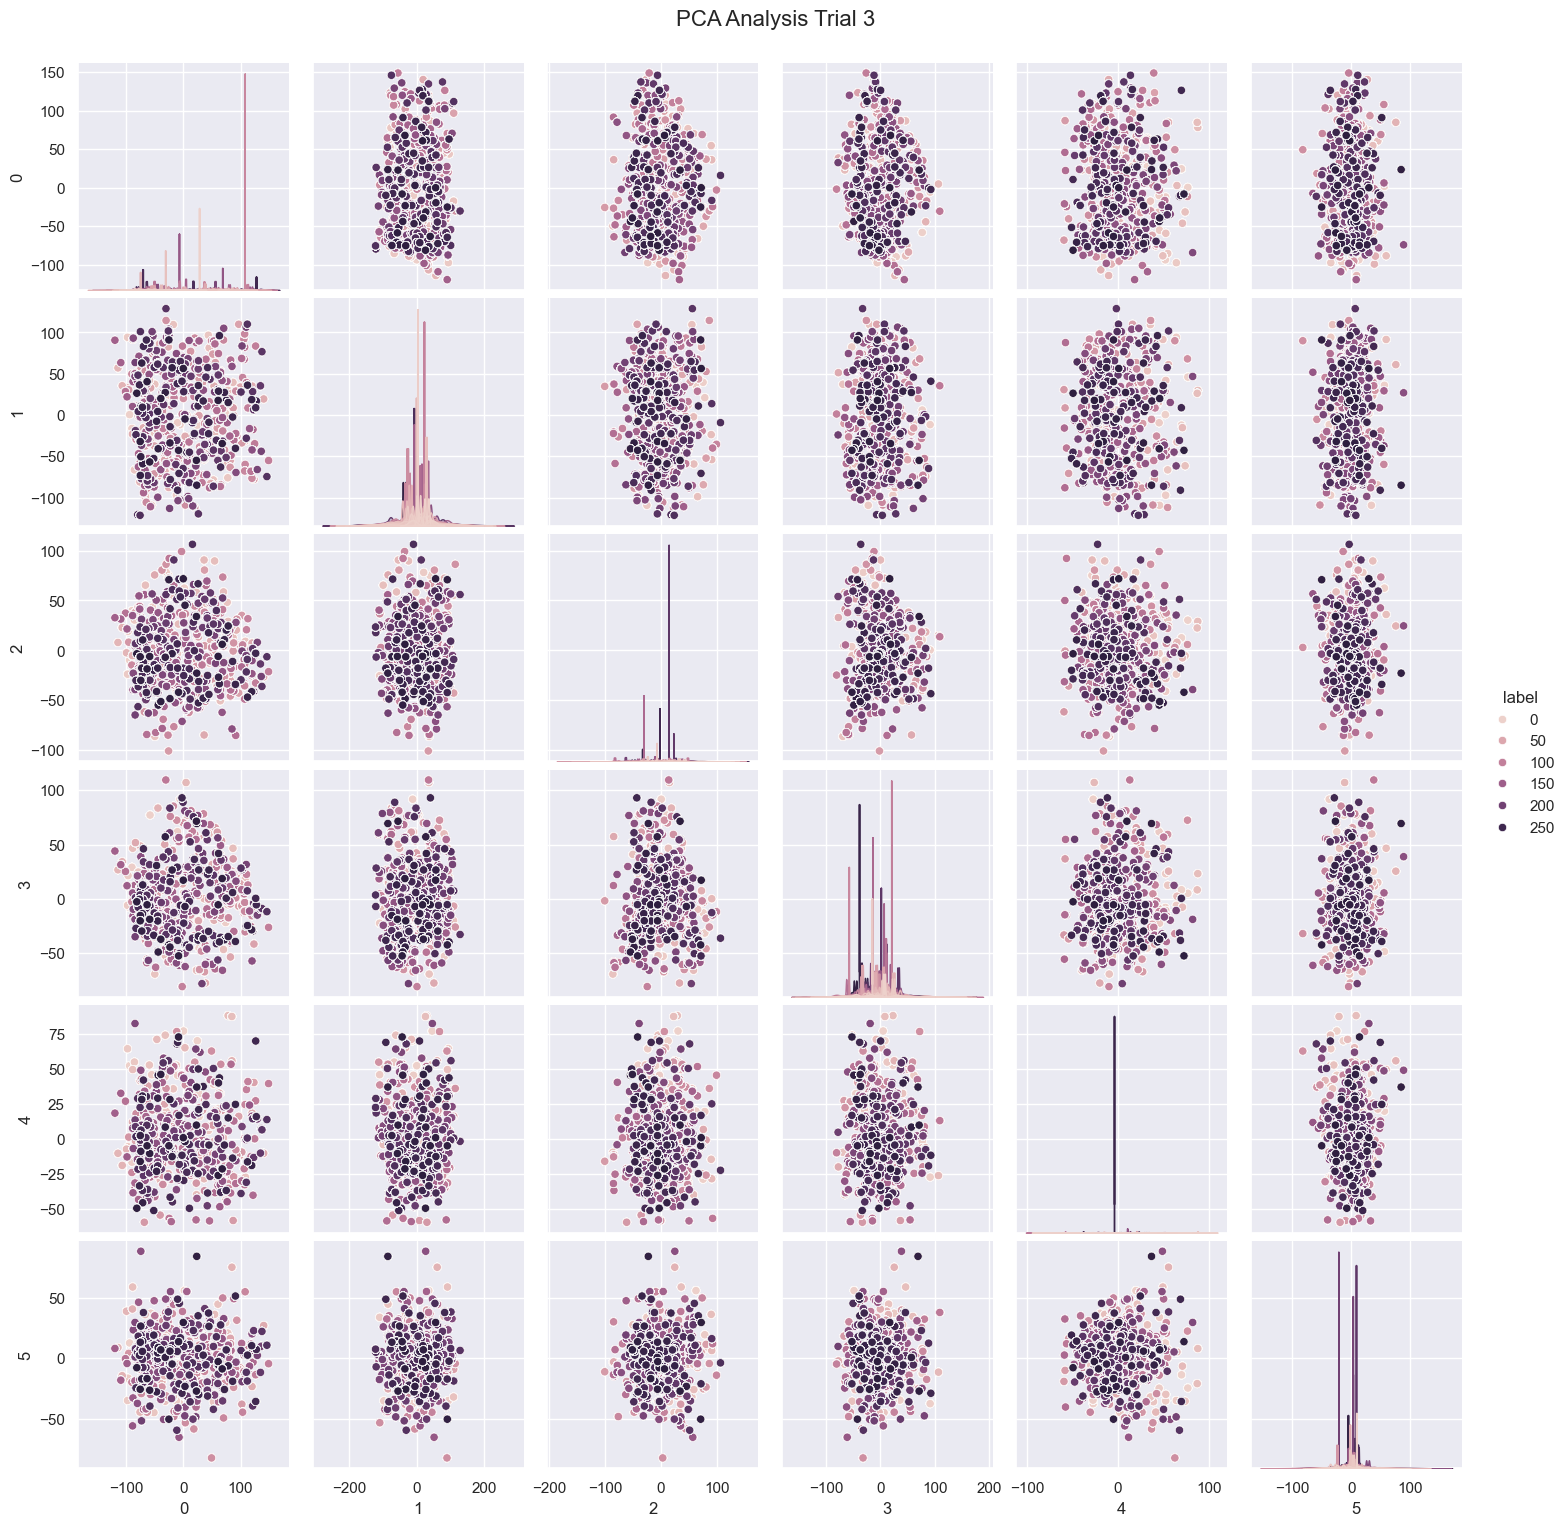

In [310]:
pca = PCA(n_components=6)
Xa_pca = pca.fit_transform(Xa3)
pca_res = pd.DataFrame(data = Xa_pca)
pca_res['label'] = ya

pairplot_fig = sns.pairplot(pca_res, hue='label')
pairplot_fig.fig.suptitle('PCA Analysis Trial 3', size=16, y=1.02)
pairplot_fig.savefig("trial3_feature_validation_pca_pairplot.png")
plt.show()

### 4.2.2 Linear Discriminant Analysis

LDA technique is employed to extract insights into class separability.

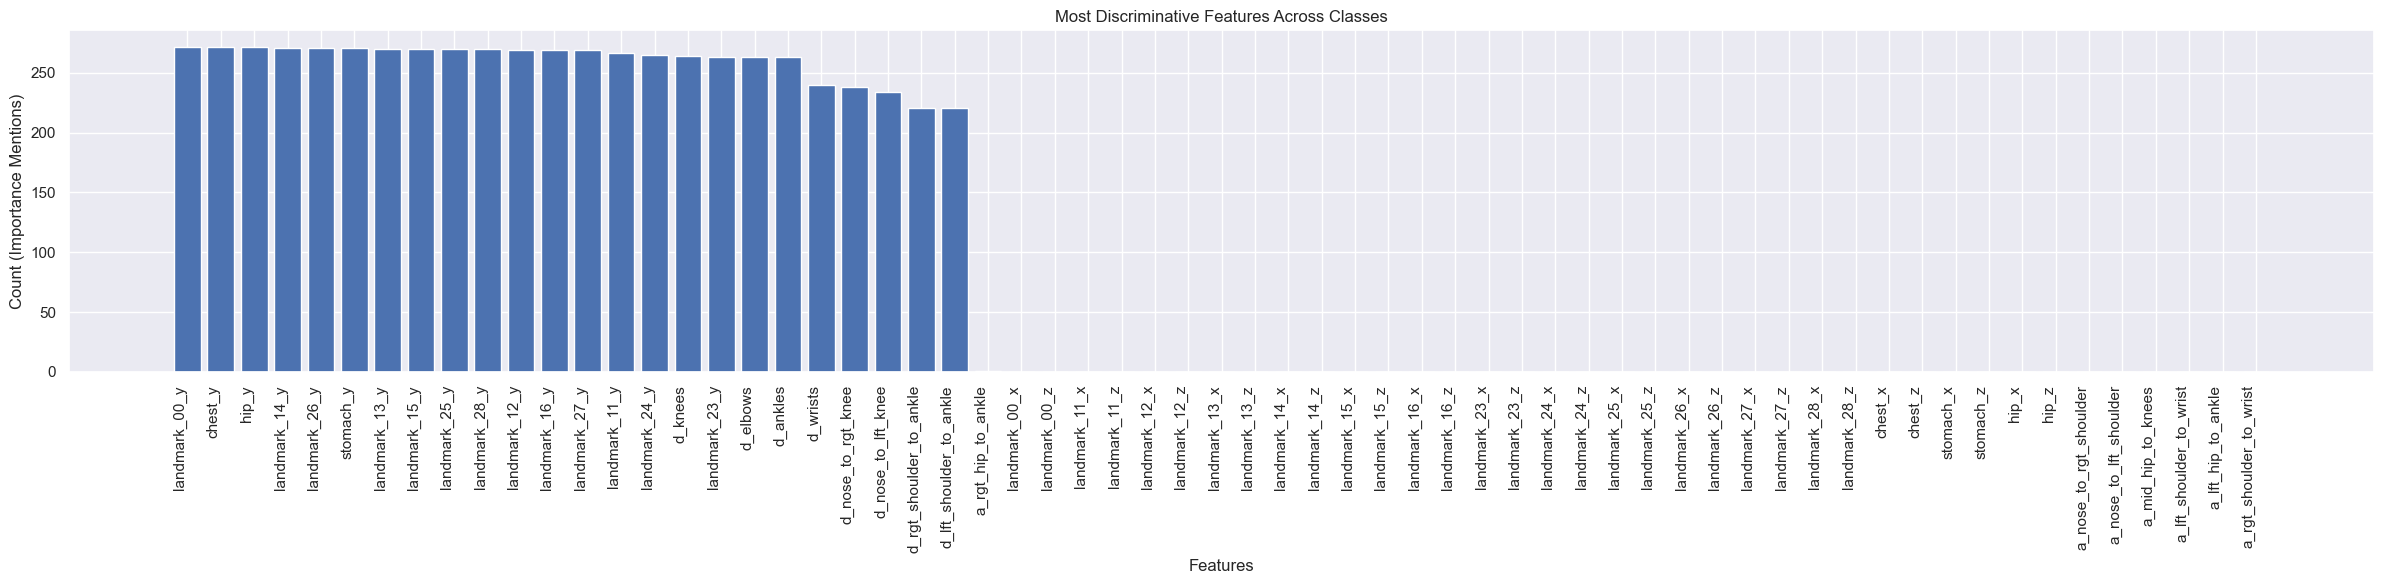

In [335]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(Xa3, ya3)
features = Xa3.columns

n_top_features = 23
feature_counts = {feature: 0 for feature in features}

top_features_per_class = {}
for i in range(lda.coef_.shape[0]):
  sorted_coef_indices = np.argsort(np.abs(lda.coef_[i]))[::-1]
  top_features = [features[j] for j in sorted_coef_indices[:n_top_features]]
  for feature in top_features:
    feature_counts[feature] += 1

  top_features_per_class[i] = top_features

sorted_feature_counts = dict(sorted(feature_counts.items(), key=lambda item: item[1], reverse=True))    
features = list(sorted_feature_counts.keys())
counts = list(sorted_feature_counts.values())

plt.figure(figsize=(24, 6))
plt.bar(features, counts)
plt.xlabel("Features")
plt.ylabel("Count (Importance Mentions)")
plt.title("Most Discriminative Features Across Classes")
plt.xticks(rotation=90, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

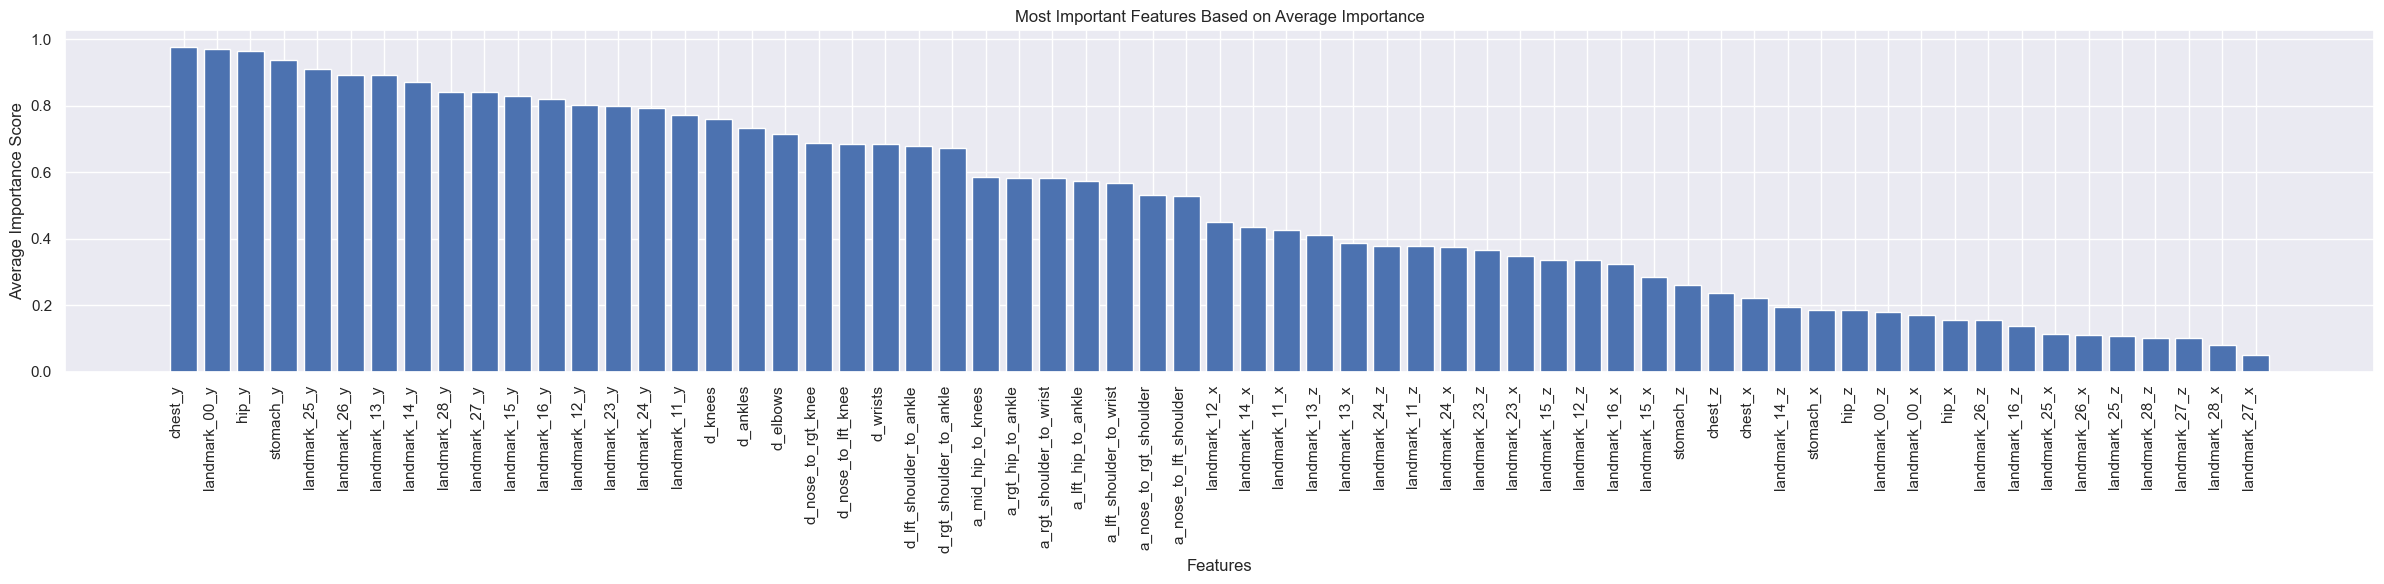

In [342]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(Xa3, ya3)
features = Xa3.columns

total_features = len(Xa3.columns)

# Calculate importance score based on position in the sorted list
feature_importances = {}
for i in range(lda.coef_.shape[0]):
  sorted_coef_indices = np.argsort(np.abs(lda.coef_[i]))[::-1]
  for j, idx in enumerate(sorted_coef_indices):
    feature = features[idx]
    # Importance score based on position (higher position gets higher score)
    score = 1 - (j / (total_features - 1))
    feature_importances[feature] = feature_importances.get(feature, 0) + score

# Sort features and importance scores by average importance
sorted_importances = dict(sorted(feature_importances.items(), key=lambda item: item[1], reverse=True))
features = list(sorted_importances.keys())
average_importances = [sorted_importances[f] / len(lda.coef_) for f in features]  # Average importance across classes

plt.figure(figsize=(24, 6))
plt.bar(features, average_importances)
plt.xlabel("Features")
plt.ylabel("Average Importance Score")
plt.title("Most Important Features Based on Average Importance")
plt.xticks(rotation=90, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

## 4.3 KNN Classification

### 4.3.2 PCA-Reduced KNN Training Validation

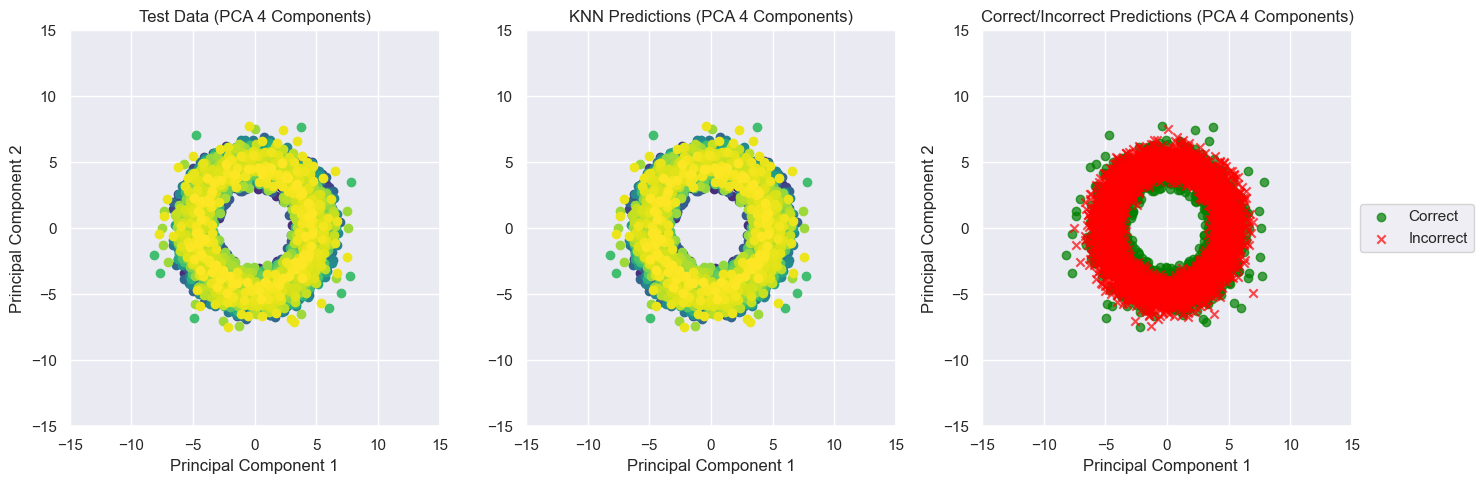

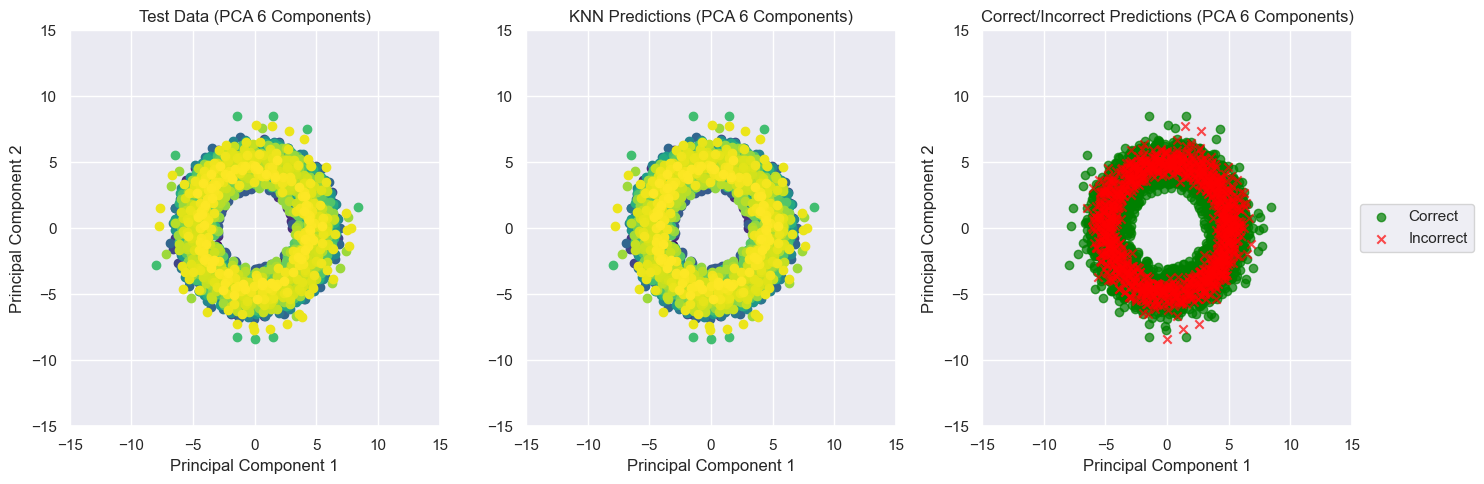

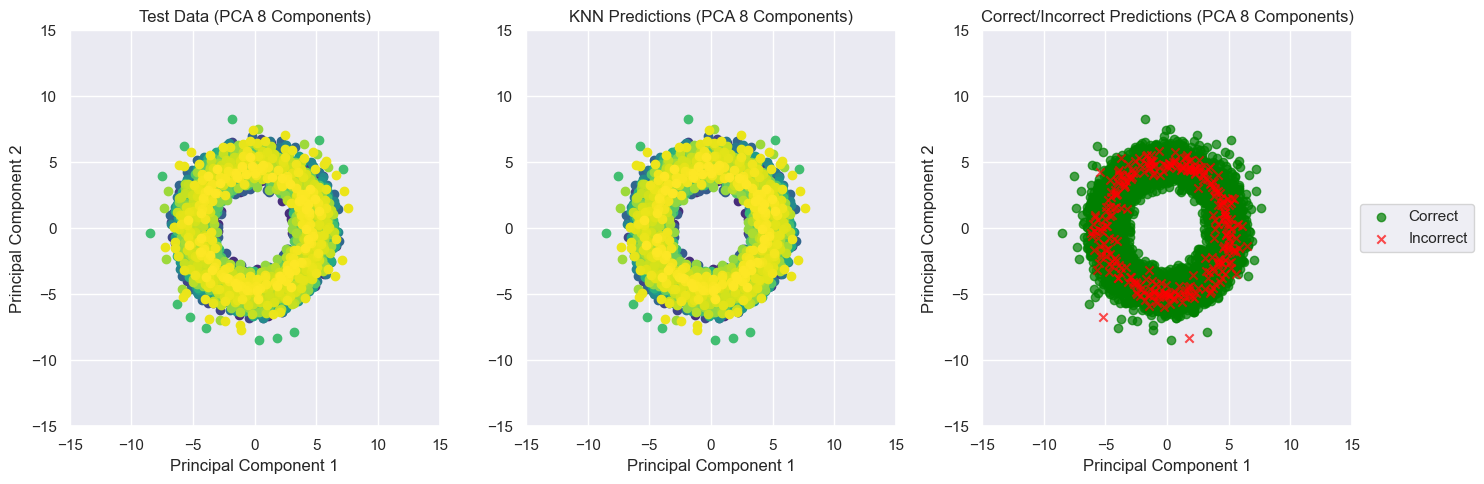

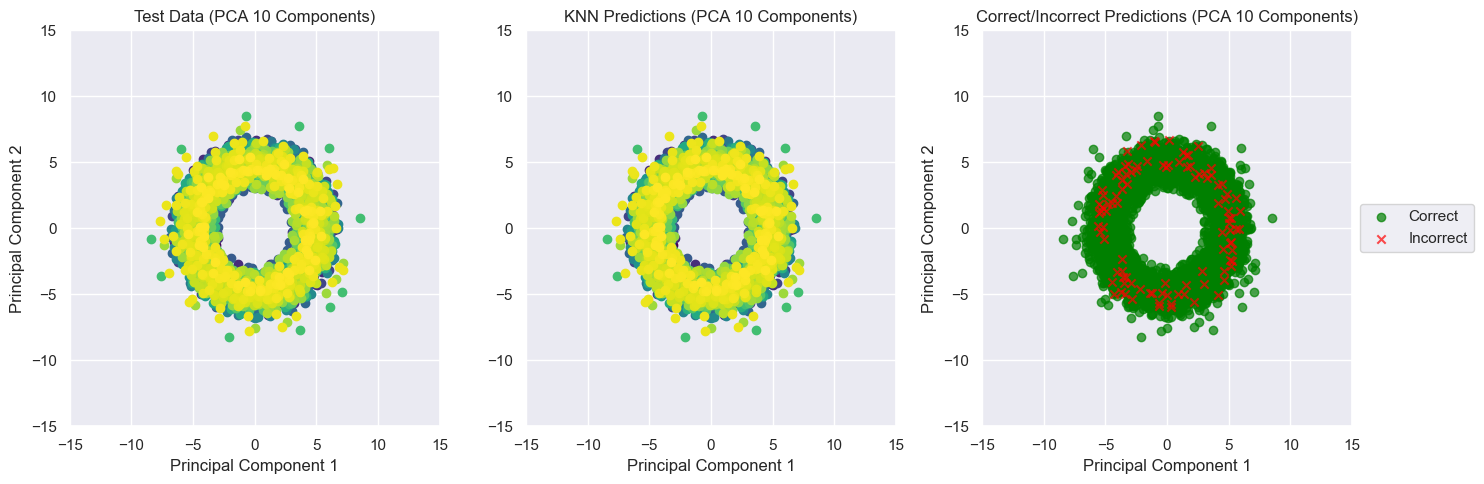

In [319]:
from helpers.pca_pipelines import pca_reduced_knn_training_validation

accuracy1, precision1, recall1, f11, conf_matrix1 = pca_reduced_knn_training_validation(
    Xa3_scaled,ya3,poses_names,n_neighbors=1, n_components=4, test_size=0.3)

accuracy2, precision2, recall2, f12, conf_matrix2 = pca_reduced_knn_training_validation(
    Xa3_scaled,ya3,poses_names,n_neighbors=1, n_components=6, test_size=0.3)

accuracy3, precision3, recall3, f13, conf_matrix3 = pca_reduced_knn_training_validation(
    Xa3_scaled,ya3,poses_names,n_neighbors=1, n_components=8, test_size=0.3)

accuracy4, precision4, recall4, f14, conf_matrix4 = pca_reduced_knn_training_validation(
    Xa3_scaled,ya3,poses_names,n_neighbors=1, n_components=10, test_size=0.3)

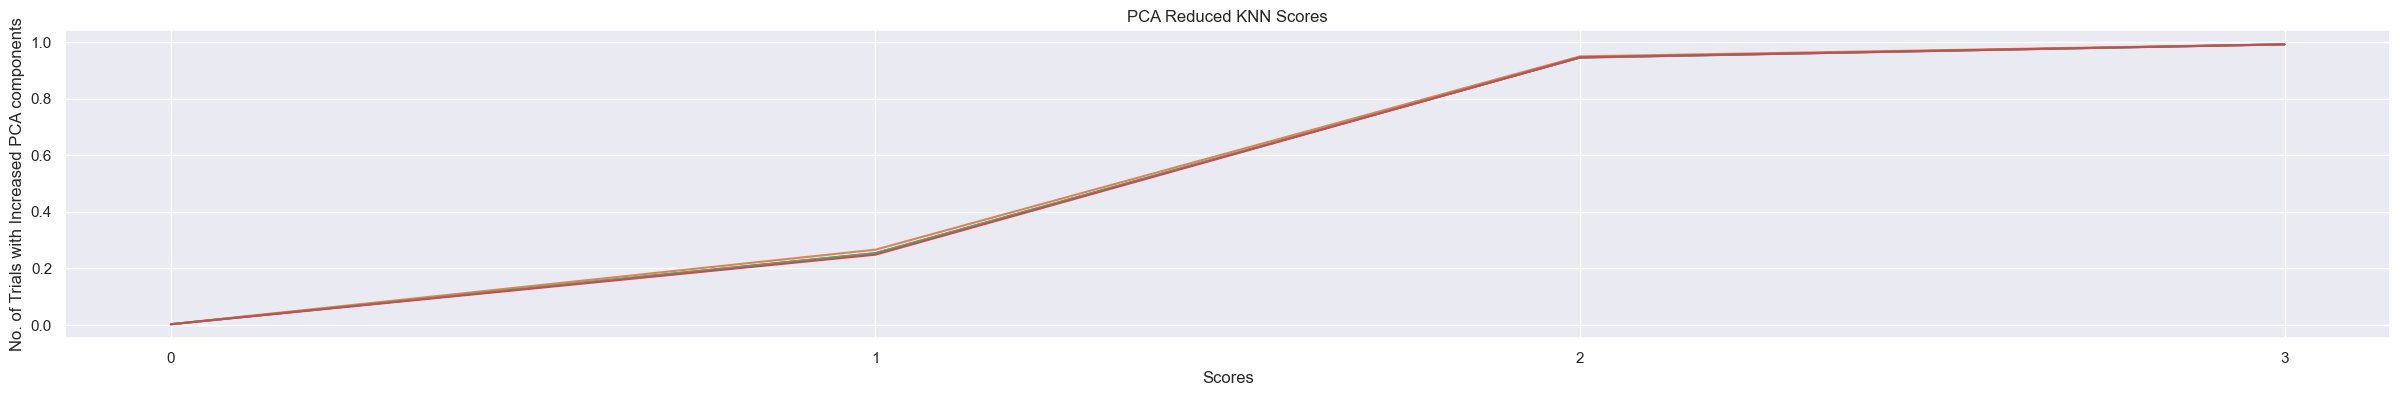

In [318]:
accuracy = [accuracy1,accuracy2,accuracy3,accuracy4]
precision = [precision1,precision2,precision3,precision4]
recall = [recall1,recall2,recall3,recall4]
f1 = [f11,f12,f13,f14]

sns.set(rc={'figure.figsize':(30,4)})
plt.plot(accuracy)
plt.plot(precision)
plt.plot(recall)
plt.plot(f1)
plt.xticks(range(len(accuracy))[::1])
plt.title("PCA Reduced KNN Scores")
plt.xlabel("Scores")
plt.ylabel("No. of Trials with Increased PCA components")
plt.grid(True)
plt.show()

In [320]:
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: [0.002382573179033356, 0.25357385976855, 0.9452008168822328, 0.992001361470388]
Precision: [0.002609174547561971, 0.26599483296957294, 0.9494952776144603, 0.9924160080872372]
Recall: [0.0023714031066972246, 0.25374013241660304, 0.9453940667175962, 0.9919786096256684]
F1 Score: [0.0023637543252595155, 0.24839545606273095, 0.9460667759197295, 0.9919754387188504]


In [321]:
print(f"Accuracy: {accuracy3}")
print(f"Precision: {precision3}")
print(f"Recall: {recall3}")
print(f"F1 Score: {f13}")

Accuracy: 0.9497957794417972
Precision: 0.952448581988897
Recall: 0.9498265215176979
F1 Score: 0.9502781397190626


### 4.3.2 LDA-Reduced KNN Training Validation

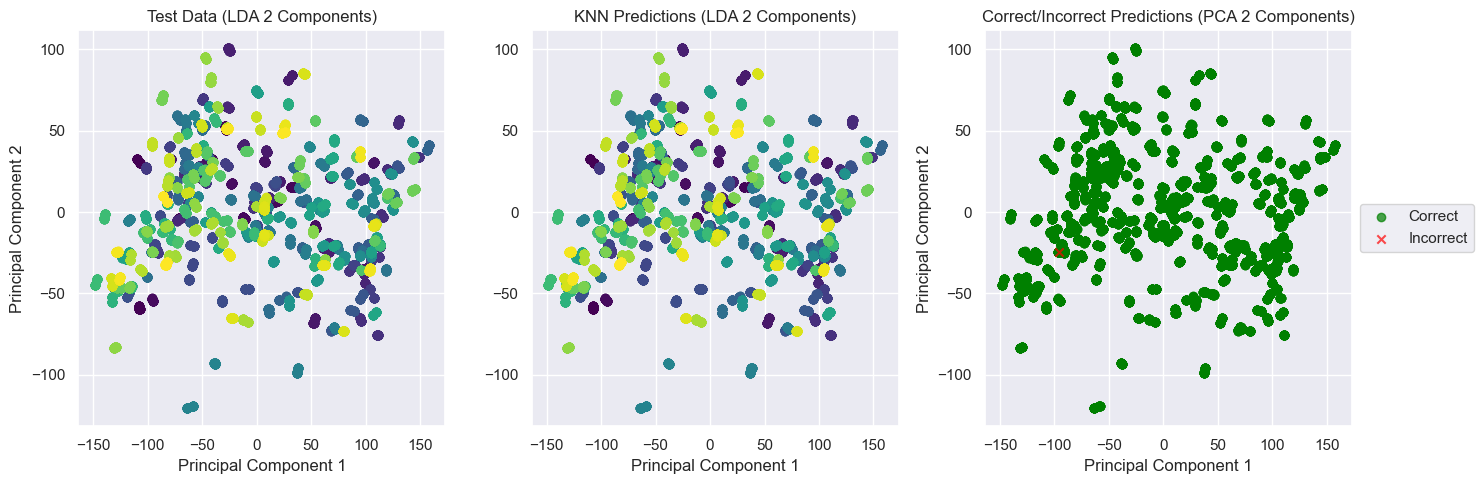

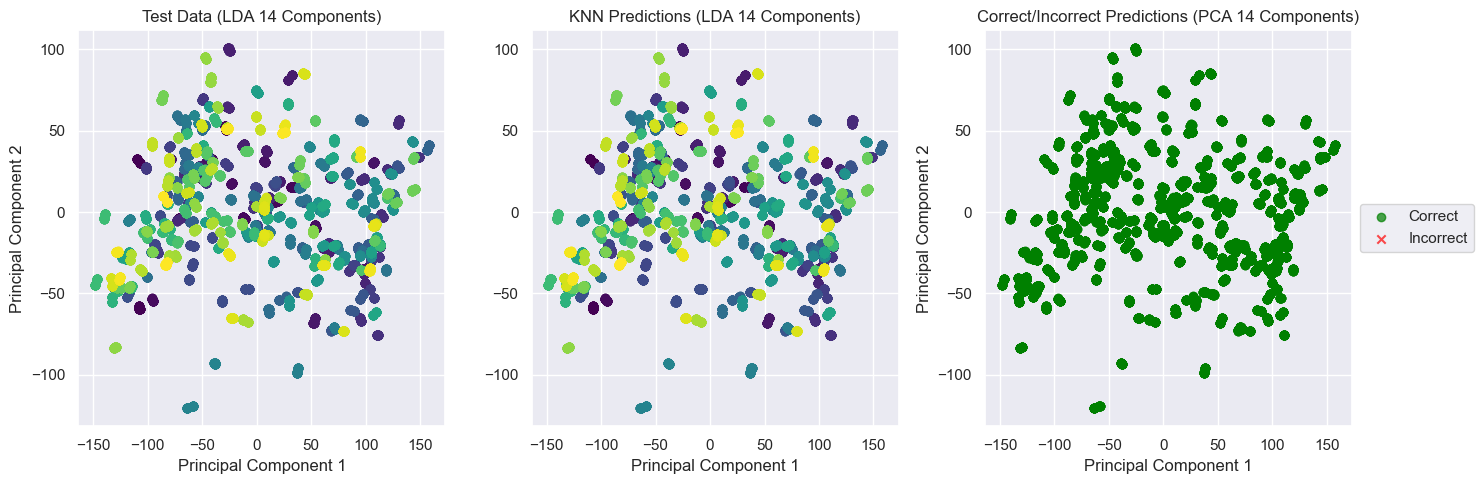

In [345]:
def lda_reduced_knn_training_validation(X,y,poses_names,n_neighbors=1, n_components=1, test_size=0.3):
    unique_poses = np.unique(poses_names)
    color_values = cm.viridis(np.linspace(0, 1, num=len(unique_poses)))

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test, pose_names_train, pose_names_test = train_test_split(
        X_scaled, y, poses_names, stratify=y, test_size=test_size, random_state=42)
    
    lda = LinearDiscriminantAnalysis(n_components=n_components)
    X_train_lda = lda.fit_transform(X_train,y_train)
    X_test_lda = lda.transform(X_test)

    model = KNeighborsClassifier(n_neighbors=n_neighbors, weights='distance')
    model.fit(X_train_lda, y_train)

    y_pred = model.predict(X_test_lda)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    conf_matrix = confusion_matrix(y_test, y_pred)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for i, pose in enumerate(unique_poses):
        idx = pose_names_test == pose
        axes[0].scatter(X_test_lda[idx, 0], X_test_lda[idx, 1], color=color_values[i], label=pose)
    axes[0].set_title(f'Test Data (LDA {n_components} Components)')
    axes[0].set_xlabel('Principal Component 1')
    axes[0].set_ylabel('Principal Component 2')
    axes[0].grid(True)
    #axes[0].set_xlim([-10, 10])
    #axes[0].set_ylim([-10, 10])

    # Predictions Plot
    for i, pose in enumerate(unique_poses):
        idx = pose_names_test == pose
        axes[1].scatter(X_test_lda[idx, 0], X_test_lda[idx, 1], color=color_values[i], label=pose)
    axes[1].set_title(f'KNN Predictions (LDA {n_components} Components)')
    axes[1].set_xlabel('Principal Component 1')
    axes[1].grid(True)
    #axes[1].set_xlim([-10, 10])
    #axes[1].set_ylim([-10, 10])

    # True Labels Plot
    correct = y_pred == y_test
    incorrect = ~correct
    axes[2].scatter(X_test_lda[correct, 0], X_test_lda[correct, 1], c='green', marker='o', alpha=0.7, label='Correct')
    axes[2].scatter(X_test_lda[incorrect, 0], X_test_lda[incorrect, 1], c='red', marker='x', alpha=0.7, label='Incorrect')
    axes[2].set_title(f'Correct/Incorrect Predictions (PCA {n_components} Components)')
    axes[2].set_xlabel('Principal Component 1')
    axes[2].set_ylabel('Principal Component 2')
    axes[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    axes[2].grid(True)
    #axes[2].set_xlim([-10, 10])
    #axes[2].set_ylim([-10, 10])    
    
    if len(unique_poses) < 6:
        axes[0].legend(loc='lower center', bbox_to_anchor=(0.5, -0.5), fontsize='small', ncol=2)
        
    plt.tight_layout()
    plt.show()
    return accuracy, precision, recall, f1, conf_matrix

lda_reduced_knn_training_validation

accuracy1, precision1, recall1, f11, conf_matrix1 = lda_reduced_knn_training_validation(
    Xa3_scaled,ya,poses_names,n_neighbors=1, n_components=2, test_size=0.5)

accuracy2, precision2, recall2, f12, conf_matrix2 = lda_reduced_knn_training_validation(
    Xa3_scaled,ya,poses_names,n_neighbors=1, n_components=14, test_size=0.5)

In [369]:
test_data = pd.read_csv('data/testing-set-1/processed/test-chair-spin/pose_data_res.csv')
test_data = test_data.loc[:, ~test_data.columns.str.contains('_v')] #Removed Visibility Variable
Xt = pd.concat([test_data.iloc[:, 3:6], test_data.iloc[:, 36:54], test_data.iloc[:, 72:90], test_data.iloc[:, 102:]],axis=1)

In [394]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Model Training
model = KNeighborsClassifier(n_neighbors=50)
model.fit(Xa3, poses_names)  # Train model on the original training data

# Prediction
y_pred = model.predict(Xt)  # Predict labels for the original test data
print(y_pred)

['supported-sailboat' 'handspring-fang' 'carousel-spin'
 'front-armpit-hold-attitude' 'layback-plank-lower-support'
 'scissor-spin-baseball-grip' 'pencil-spin-forearm-grip' 'bat-wing' 'hawk'
 'reverse-grab-pencil' 'bow-and-arrow' 'inverted-d'
 'unicorn-russian-layback-bridge' 'superpain-no-hands-superman'
 'tucked-cradle-spin' 'hip-lock-tuck-drama-queen' 'fireman-spin'
 'seated-tuck' 'libellula-variation' 'one-handed-spin'
 'one-hand-lateral-slide' 'flag-grip-pencil'
 'frodo-cradle-spin-pike-no-hands' 'bow-and-arrow-no-hands' 'one-arm-flag'
 'one-arm-flag' 'elbow-mount-straddle' 'windmill-spin'
 'split-grip-leg-through-frontal-split' 'pike-sit-elbow-grip' 'doris-spin'
 'doris-spin' 'pike-sit-elbow-grip' 'supported-sailboat'
 'one-hand-lateral-slide' 'supported-sailboat'
 'elbow-grip-pencil-inverted' 'pike-sit-elbow-grip' 'supported-sailboat'
 'pike-sit-elbow-grip' 'pole-toe-walk' 'supported-sailboat'
 'plank-hand-on-top' 'elbow-grip-pencil-inverted'
 'elbow-grip-pencil-inverted' 'elbow

## 4.4 Side Experiment: Similar Pose Classes using LDA

The results from training and validating the KNN model on the LDA-reduced dataset were similar to previous trials. In this experiment, we aim to identify classes that appear inseparable to determine which features might effectively distinguish them.

In [347]:
from scipy.spatial.distance import pdist, squareform

lda = LinearDiscriminantAnalysis(n_components=1)
X_lda = lda.fit_transform(Xa3_scaled,ya3)
results = pd.DataFrame(X_lda, columns=['lda'])
results['label'] = poses_names
results = results.groupby('label')['lda'].mean().reset_index()

labels = results['label']
distances = pd.DataFrame(np.zeros((len(labels), len(labels))), columns=labels, index=labels)

for i in range(len(labels)):
    for j in range(len(labels)):
        distances.iloc[i, j] = abs(results.iloc[i]['lda'] - results.iloc[j]['lda'])

distances

label,advanced-figurehead,aerial-leg-hold-crucifix,air-walk,alesia-half-split,allegra,allegra-split,anastasia,apprentice,armpit-hold-hang-teddy-passe,armpit-hold-pike-teddy-pike,...,two-hand-side-hold,two-handed-full-bracket-split,unicorn-russian-layback-bridge,vertical-duchess-jade-variation,vortex-back,vortex-front,windmill-spin,wrist-sit,yogini,yogini-twisted
label,,,,,,,,,,,,,,,,,,,,,
advanced-figurehead,0.000000,0.533322,37.206815,79.994620,141.326929,126.614882,66.681911,96.851200,12.486010,85.209447,...,133.686096,82.877225,212.362243,203.295698,20.062844,17.896078,81.472757,132.902850,24.278865,25.374286
aerial-leg-hold-crucifix,0.533322,0.000000,36.673493,79.461297,140.793607,126.081560,66.148589,96.317878,11.952688,84.676125,...,133.152774,82.343903,211.828921,202.762376,20.596166,18.429400,80.939434,132.369528,23.745543,24.840964
air-walk,37.206815,36.673493,0.000000,42.787805,104.120115,89.408068,29.475096,59.644385,24.720805,48.002632,...,96.479282,45.670410,175.155428,166.088883,57.269659,55.102893,44.265942,95.696036,12.927950,11.832529
alesia-half-split,79.994620,79.461297,42.787805,0.000000,61.332310,46.620263,13.312709,16.856580,67.508610,5.214827,...,53.691477,2.882605,132.367623,123.301078,100.057464,97.890698,1.478137,52.908231,55.715755,54.620333
allegra,141.326929,140.793607,104.120115,61.332310,0.000000,14.712047,74.645018,44.475730,128.840919,56.117483,...,7.640833,58.449704,71.035313,61.968768,161.389774,159.223007,59.854173,8.424079,117.048064,115.952643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vortex-front,17.896078,18.429400,55.102893,97.890698,159.223007,144.510960,84.577989,114.747278,30.382088,103.105525,...,151.582174,100.773303,230.258321,221.191776,2.166766,0.000000,99.368835,150.798928,42.174943,43.270364
windmill-spin,81.472757,80.939434,44.265942,1.478137,59.854173,45.142126,14.790845,15.378443,68.986747,3.736690,...,52.213340,1.404468,130.889486,121.822941,101.535601,99.368835,0.000000,51.430094,57.193892,56.098470
wrist-sit,132.902850,132.369528,95.696036,52.908231,8.424079,6.287968,66.220939,36.051651,120.416840,47.693403,...,0.783246,50.025625,79.459393,70.392848,152.965695,150.798928,51.430094,0.000000,108.623985,107.528564


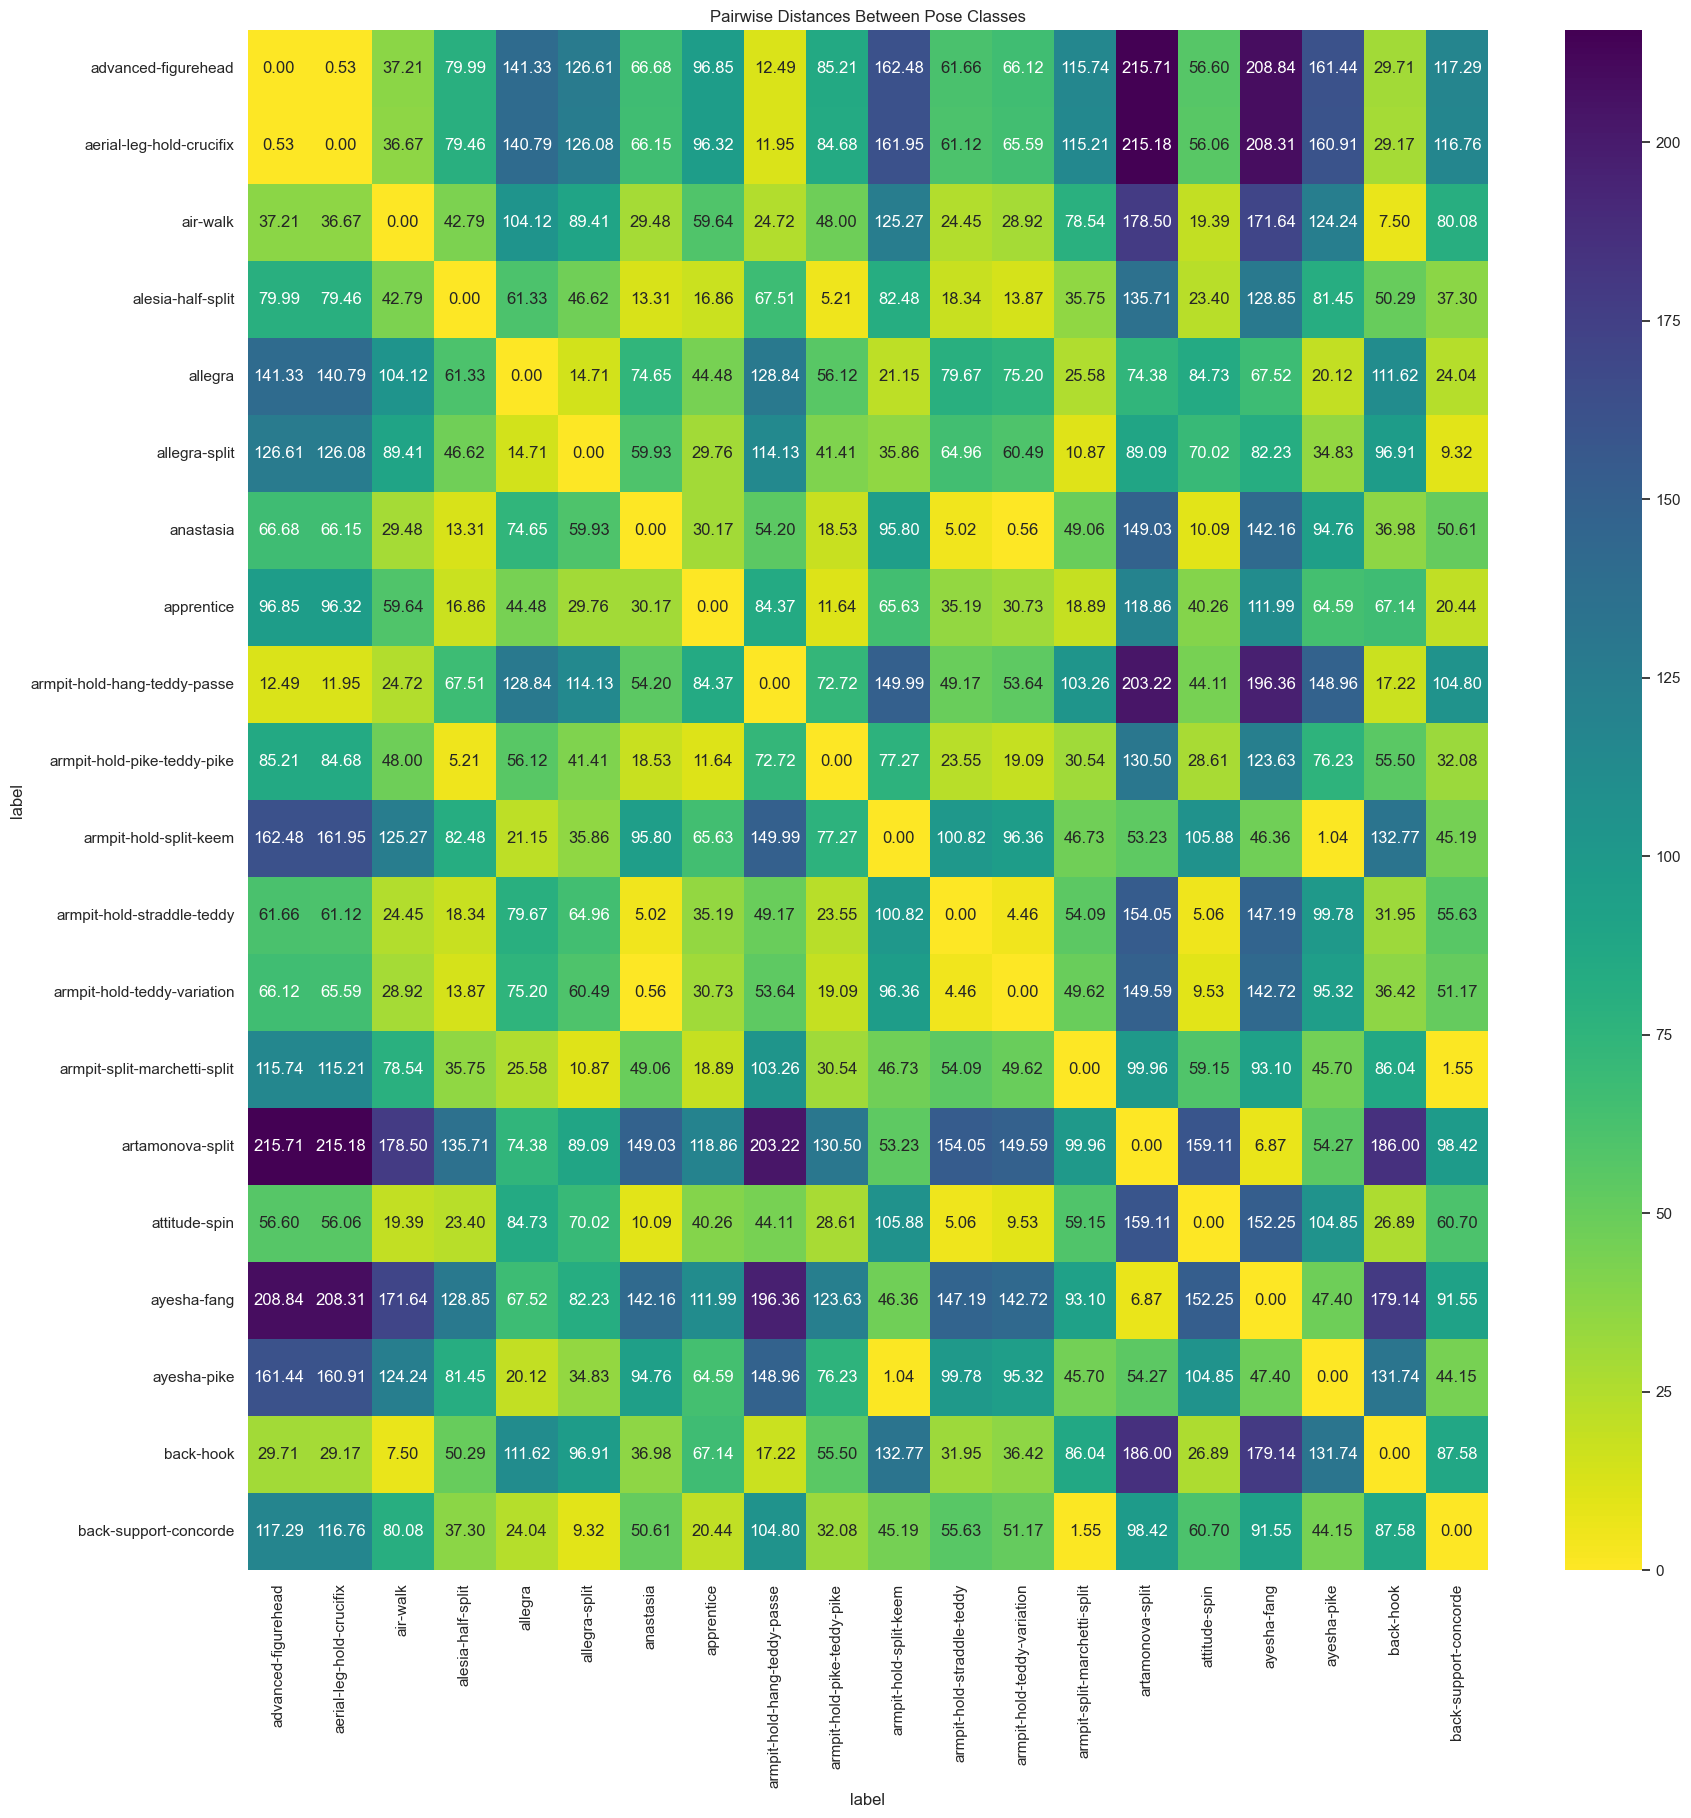

In [357]:
plt.figure(figsize=(20, 20))
sns.heatmap(distances.iloc[:20,:20], annot=True, fmt=".2f", cmap="viridis_r",
            xticklabels=distances.iloc[:20,:20], yticklabels=distances.iloc[:20,:20])
plt.title('Pairwise Distances Between Pose Classes')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

## Trial 3 Findings

- Cross-validation yielded higher accuracy with the selection of added features, suggesting that the feature design is effective for classification.
- The importance of dataset cleaning is underscored. To affirm pose closeness, poses must share similar characteristics (e.g., grip, leg position).
- Although class separability is noted among a smaller number of classes, they are still grouped together, indicating the need for additional features.
- For the subsequent trial, it is recommended to apply KNN on test data. This will evaluate the model's ability to generalize to both known and unknown classes effectively.
